# SiPM calibration

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

### Objective

Objective: produces a file with the SiPM calibration parameters: noise, dark current, gain.

author: Jose A. Hernando
version: v0_00 

### Revision

In [3]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

21/11/2016   19:59:47


### Dependencies

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import tables
import pandas as pd
import time

In [17]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [18]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Calib


### DB  

In [19]:
icdat = '/Users/hernando/Investigacion/NEXT/Data/NEWMCStar/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [20]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
h5index_of_sensorid = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('h5index of sensor id [{}]={}'.format(i0,h5index_of_sensorid[i0]))

def sipm_position_of_sensorid(senid):
    if (not h5index_of_sensorid.has_key(senid)): return [-200.,-200,0.]
    h5index = h5index_of_sensorid[senid]
    pos = sipmdb[h5index][2]
    return pos

senid=1000
pos = sipm_position_of_sensorid(senid)
print('position of sensor id {} = {}'.format(senid,pos))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
h5index of sensor id [1000]=0
position of sensor id 1000 = [  -235.     45. -10000.]


### SiPM calibration data

In [21]:
indir='/Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/161117/'
irun='2905'
infile='sipmCal_r'+irun

In [23]:
# input calibration data: dark current and led
import calib as sc
called = sc.CalData(indir+infile+'_led.txt')
caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/161117/sipmCal_r2905_led.txt
number of sensors with data 1792
loaded calibration data from file /Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/161117/sipmCal_r2905_dark.txt
number of sensors with data 1792


In [24]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

In [25]:
def position_of_indexes(indexes):
    senids = map(sc.sipm_sensorid_of_index,indexes)
    pos = map(sipm_position_of_sensorid,senids)
    return np.array(pos)

In [26]:
# take the reference values
xbins = called.xbins
indexes = called.indexes
positions = position_of_indexes(indexes)

## Calibration

### calibration to poisson and ngaussians

In [27]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
chi2, pss, covs = sc.cal_fit_poissongauss(called,indexes,ngauss=7)
zpss = zip(indexes,pss)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...
fitting data...


In [38]:
cov = covs[0]
print(cov)
print(cov[1][1])

[[  2.39443524e+05  -1.14480819e-01   4.02951433e-02   1.23773637e+00
    3.35116459e-01   4.98932022e-01]
 [ -1.14480819e-01   7.73365384e-03  -3.35202113e-03   1.13264937e-05
    4.55398310e-04  -2.21070624e-04]
 [  4.02951433e-02  -3.35202113e-03   2.50261787e-03  -6.27099222e-05
   -5.97875850e-05   1.18791281e-04]
 [  1.23773637e+00   1.13264937e-05  -6.27099222e-05   9.65101105e-04
   -2.69127844e-04   1.82948350e-04]
 [  3.35116459e-01   4.55398310e-04  -5.97875850e-05  -2.69127844e-04
    7.16618065e-03  -2.75167354e-03]
 [  4.98932022e-01  -2.21070624e-04   1.18791281e-04   1.82948350e-04
   -2.75167354e-03   2.53801285e-03]]
0.00773365384219


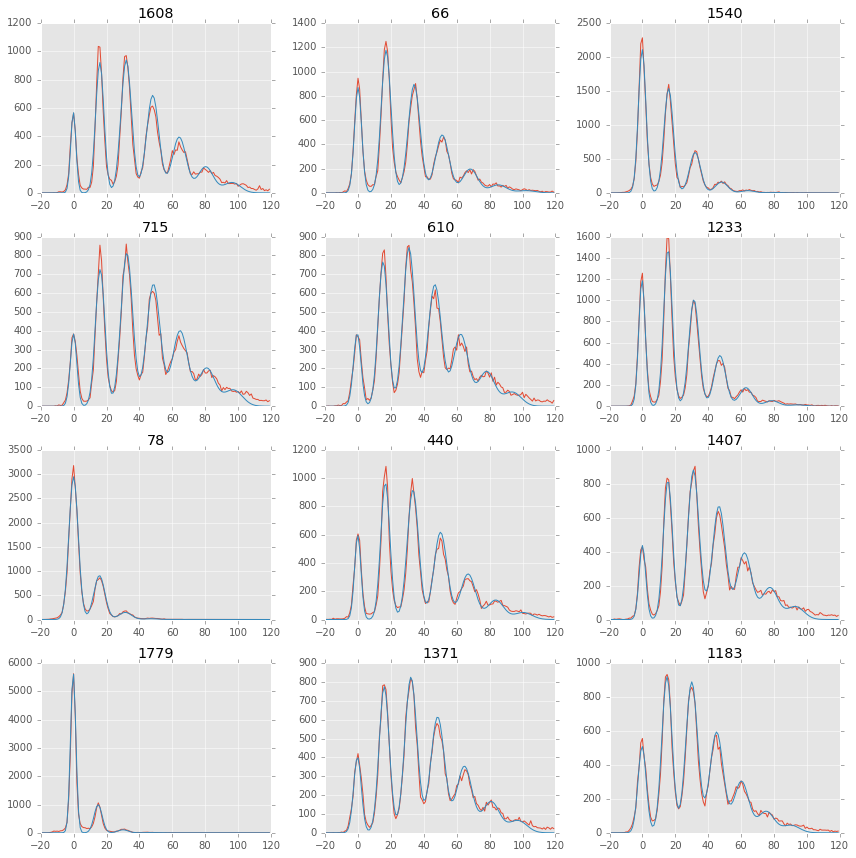

In [29]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_fits.pdf')
fun = sc.ffun_poissongauss
fig = sc.polo_cal_fit(called,indexes[:12],pss[:12],fun,xrange=(-20.,120.))
if (pdf): pdf.savefig(fig)
pdf.close()

In [46]:
pan = sc.cal_fit_poissongauss_panda(indexes, chi2, pss, covs)

In [47]:
pan.describe()

chi2        egain       enoise    enoise-pe        entot  \
count  1792.000000  1792.000000  1792.000000  1792.000000  1792.000000   
mean      5.239042     0.064573     0.068341     0.092371   406.051665   
std       1.914365     0.133977     0.027387     0.445694    71.517453   
min       0.482172     0.031726     0.011057     0.037827   123.000904   
25%       4.020072     0.045165     0.049179     0.049492   364.543546   
50%       5.014991     0.049983     0.069623     0.056850   405.997404   
75%       6.220501     0.057210     0.087335     0.071688   449.821860   
max      14.668486     3.155458     0.285780    10.977963   656.456701   

         epedestal         epes         gain      indexes        noise  \
count  1792.000000  1792.000000  1792.000000  1792.000000  1792.000000   
mean      0.076806     0.021614    16.116310   895.500000     2.159766   
std       0.035526     0.008966     0.720541   517.450159     0.563343   
min       0.014045     0.000560    12.000000     0.000000     1.250201   
25%       0.056404     0.018273    15.686843   447.750000     1.763446   
50%       0.075809     0.022968    16.069077   895.500000     2.057482   
75%       0.094671     0.026074    16.545272  1343.250000     2.393466   
max       0.839411     0.211565    18.379614  1791.000000     6.599888   

          noise-pe          ntot     pedestal          pes  
count  1792.000000   1792.000000  1792.000000  1792.000000  
mean      1.961803  29144.484581    -0.115543     1.962152  
std       0.321434    314.950230     0.405031     0.816556  
min       0.500000  27698.677786    -1.245044     0.000593  
25%       1.835656  28982.774889    -0.270921     1.612904  
50%       1.945206  29186.477067    -0.122766     2.275928  
75%       2.053489  29354.715163     0.020321     2.576169  
max       7.100534  30032.408630    10.000000     3.144362

In [49]:
pan = pan.sort_values(by='indexes')
pan.to_hdf(indir+'calf_R'+irun+'_pg_panda.h5','df',mode='w',format='table',data_columns=True)
pan.to_csv(indir+'calf_R'+irun+'_pg_panda.csv')
pan

chi2     egain    enoise  enoise-pe       entot  epedestal  \
1242   2.840684  0.036203  0.034238   0.046839  302.791409   0.042111   
1596   2.636414  0.034323  0.036245   0.045226  292.343784   0.043997   
338    4.190829  0.050398  0.033935   0.064249  364.506398   0.042463   
1791   3.045219  0.040652  0.030978   0.055089  312.058974   0.038963   
1651   2.085798  0.049786  0.031779   0.068788  259.510596   0.041014   
1448   1.973378  0.048271  0.030266   0.072608  252.156812   0.038589   
1397   1.505299  0.045183  0.025362   0.071702  220.002442   0.032178   
1297   1.381429  0.046344  0.023195   0.074636  210.503622   0.029746   
1663   3.731077  0.057932  0.027567   0.073084  342.890324   0.034857   
979    3.522175  0.058322  0.024898   0.078454  332.477011   0.031599   
817    3.419153  0.062534  0.025974   0.081640  328.061384   0.033073   
1463   3.755971  0.075404  0.025222   0.095447  342.627628   0.031817   
1578   1.795951  0.088546  0.022298   0.124281  238.293107   0.028345   
1642   1.374474  0.075164  0.019324   0.116755  208.570268   0.024482   
462    1.257072  0.080105  0.020638   0.108344  199.944431   0.025854   
884    1.355669  0.090044  0.019268   0.118901  207.241864   0.024616   
827    3.857772  0.055109  0.029173   0.069801  348.780737   0.036286   
1519   3.507398  0.049149  0.028573   0.064851  333.097325   0.035674   
1444   3.836240  0.072489  0.025586   0.090828  346.428540   0.032635   
1525   4.327873  0.064938  0.030444   0.084214  368.515980   0.038009   
1267   2.383760  0.052851  0.023540   0.073643  274.956715   0.029890   
911    2.255833  0.056192  0.021194   0.075389  267.065749   0.027231   
1393   1.972637  0.067866  0.019016   0.087832  249.303137   0.024476   
710    1.317343  0.077918  0.014981   0.093936  203.718733   0.019341   
919    4.871079  0.105730  0.026152   0.123595  388.081667   0.033211   
1031   4.088315  0.124455  0.022501   0.140560  355.611859   0.029095   
87     4.424278  0.129195  0.024418   0.138047  370.010810   0.031192   
1466   5.199385  0.137128  0.029363   0.147084  401.210302   0.036970   
292    2.276494  0.097515  0.020086   0.110127  267.527050   0.025892   
1529   1.982246  0.085167  0.019181   0.101171  249.845240   0.024481   
...         ...       ...       ...        ...         ...        ...   
252    9.429558  0.073080  0.034600   0.085802  535.121412   0.043638   
1328   7.783953  0.070046  0.039372   0.085047  490.321314   0.048247   
102    7.668810  0.102885  0.020686   0.109597  480.678535   0.026367   
1540   4.142193  0.091192  0.017685   0.100306  357.179971   0.023234   
240    9.321493  0.084420  0.026709   0.093377  529.949951   0.033516   
26     4.893110  0.077885  0.020131   0.088866  388.091386   0.026352   
1523   5.781875  0.044651  0.045967   0.051274  428.695394   0.054322   
383    7.668065  0.048292  0.045157   0.053698  489.861224   0.053134   
1104   6.713734  0.048256  0.057146   0.052818  462.669365   0.064751   
1512   6.347533  0.043288  0.048610   0.048509  448.906070   0.055554   
458    5.450481  0.048507  0.027499   0.059988  411.759225   0.034832   
519    8.767641  0.053056  0.033270   0.059016  518.436186   0.041071   
1436   4.884595  0.040131  0.028959   0.047373  391.780806   0.035748   
333   11.182380  0.057586  0.046374   0.059148  585.102991   0.055644   
66     9.130440  0.171367  0.029433   0.173413  524.057738   0.036915   
133   11.204247  0.206566  0.033298   0.201716  578.423227   0.041725   
409   11.073669  0.165080  0.033930   0.170688  575.294202   0.043101   
9     11.196827  0.110002  0.030401   0.123250  577.358982   0.038076   
535    9.392007  0.652032  0.029871   0.557609  532.572419   0.034473   
1608   9.628593  0.761580  0.028193   0.592684  539.204480   0.032695   
17     6.017896  0.120397  0.023087   0.138319  428.317436   0.029671   
1107   9.867620  0.146518  0.025716   0.158258  542.237450   0.031885   
700   10.280132  0.070737  0.034537   0.084154  556.805098   0.042151

## Compare with DB

## Plotting

### Plotting parameters

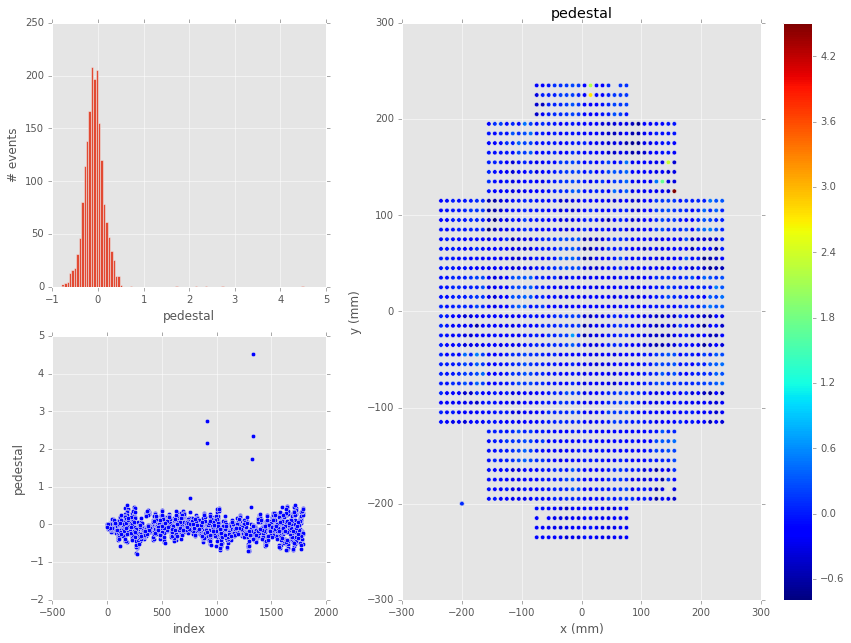

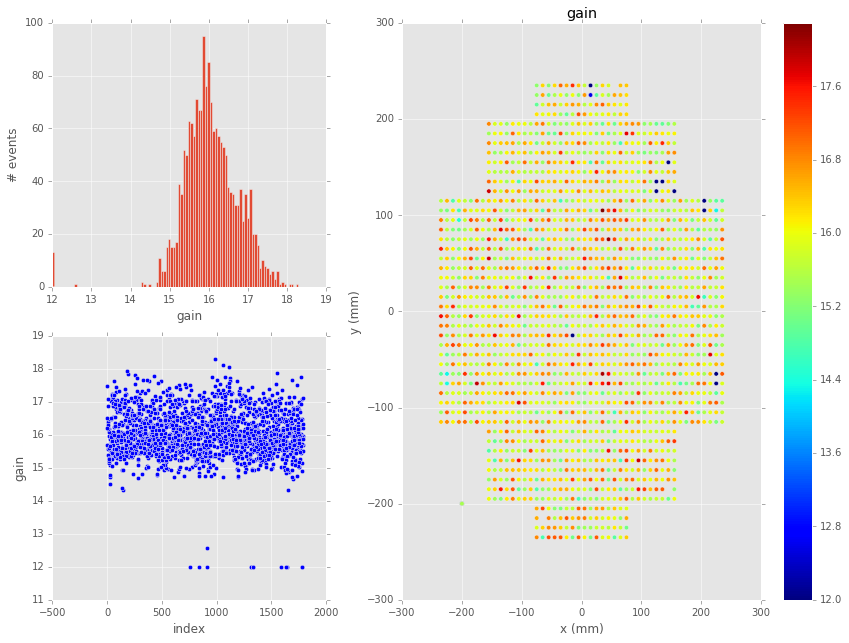

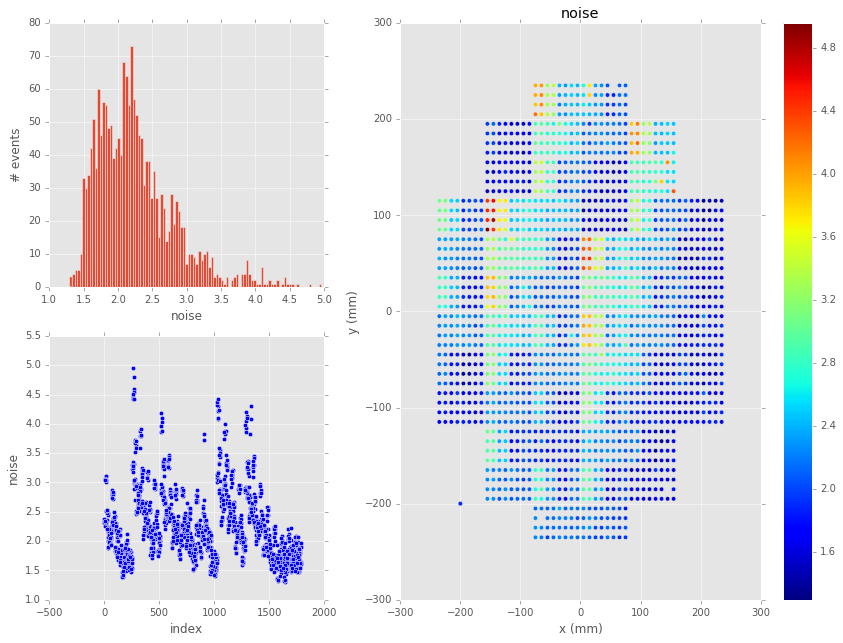

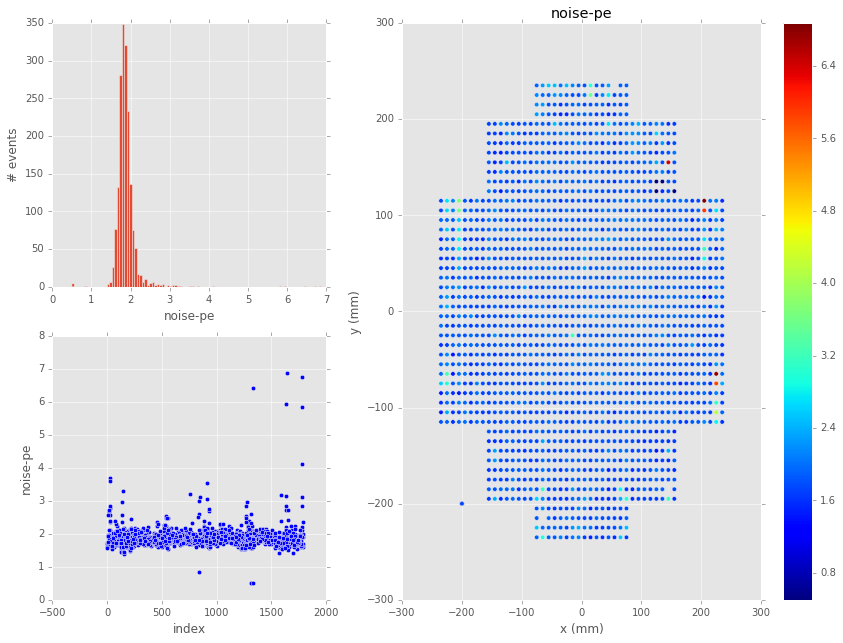

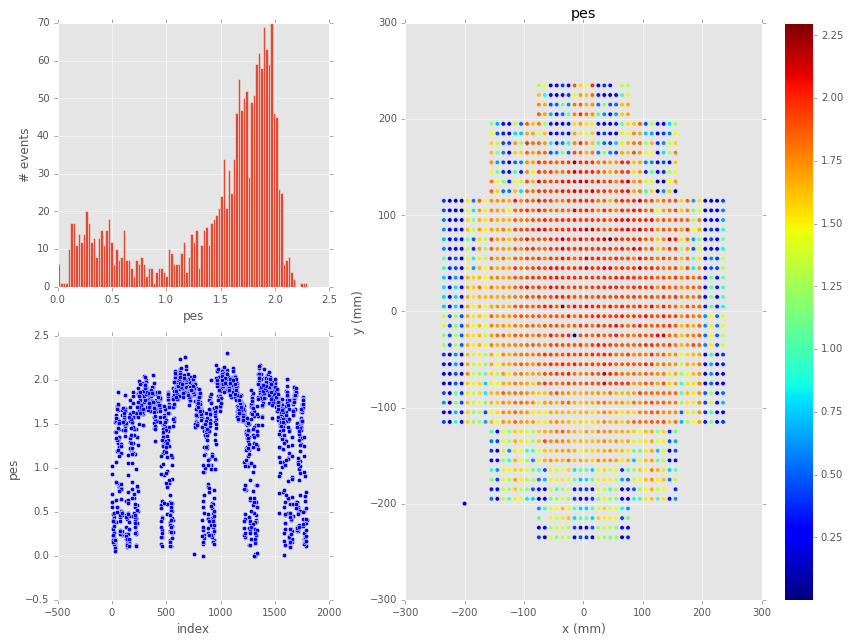

In [49]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_figs.pdf')
labels = ['pedestal','gain','noise','noise-pe','pes']
for label in labels:
    fig = sc.polo_pars(pan['indexes'],pan[label],positions,label=label)
    if (pdf): pdf.savefig(fig)
pdf.close()

In [50]:
zpss = zip(indexes,pss)
def pss_filter(findexes,zpss):
    ixs = list(findexes)
    fzs = filter(lambda z: z[0] in ixs,zpss)
    fpss = map(lambda z: z[1],fzs)
    return fpss

In [51]:
### Plotting SiPM spectrum of SiPMs with parameters in the tails of the distributions

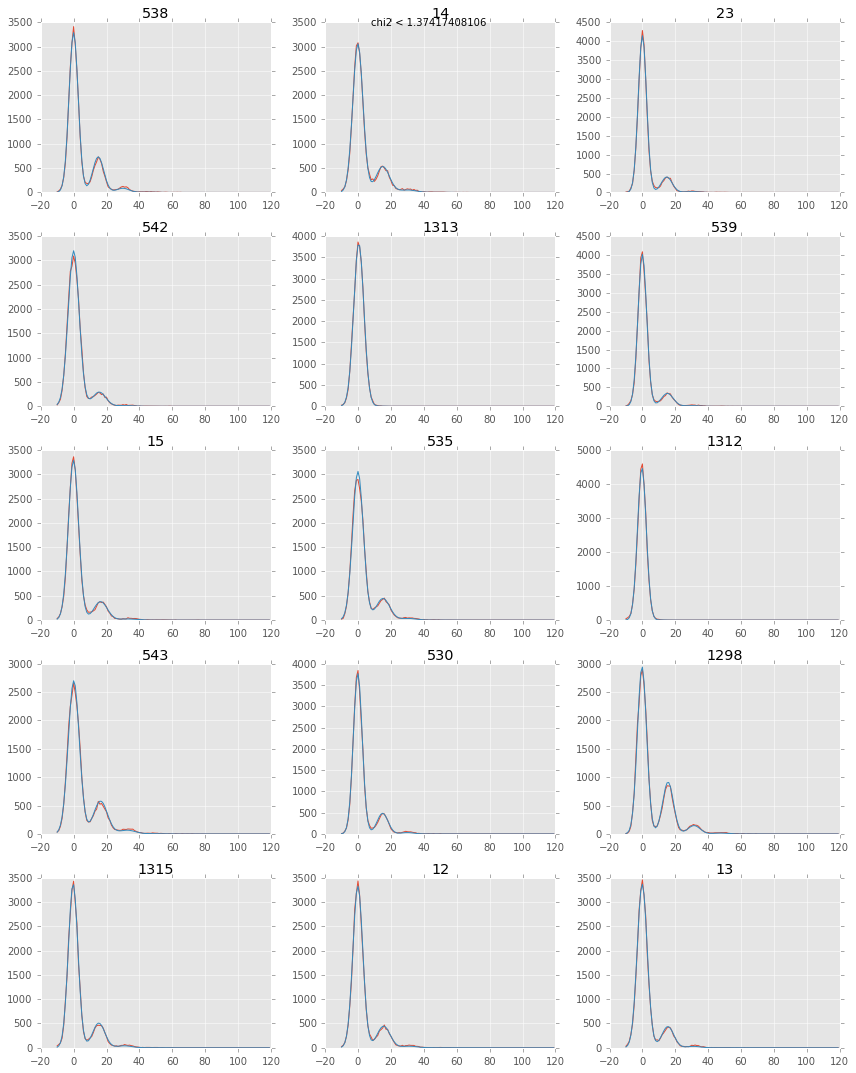

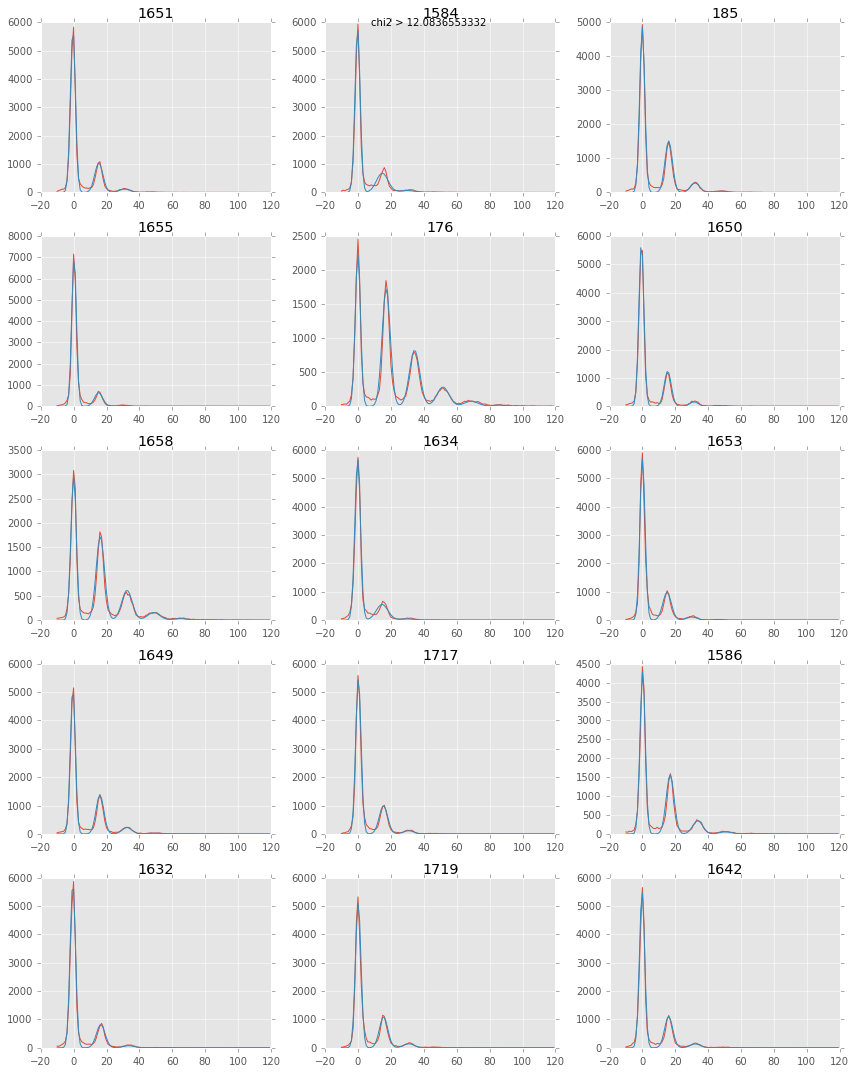

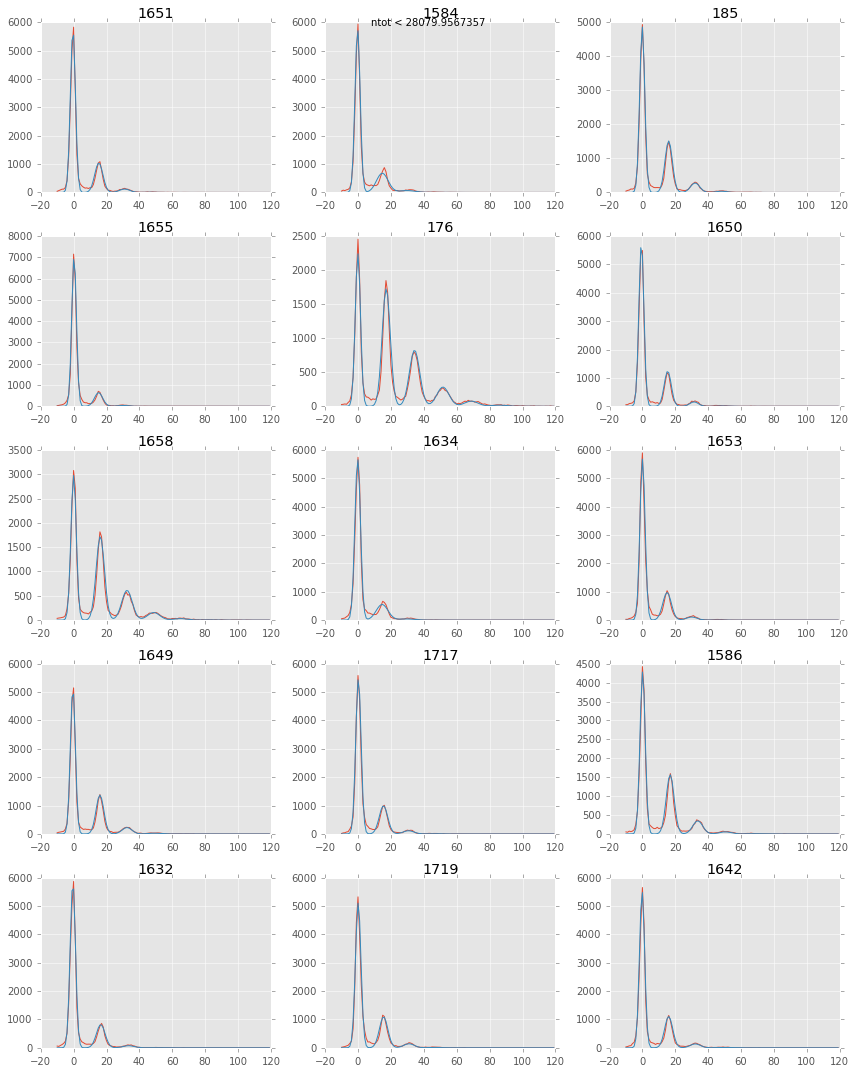

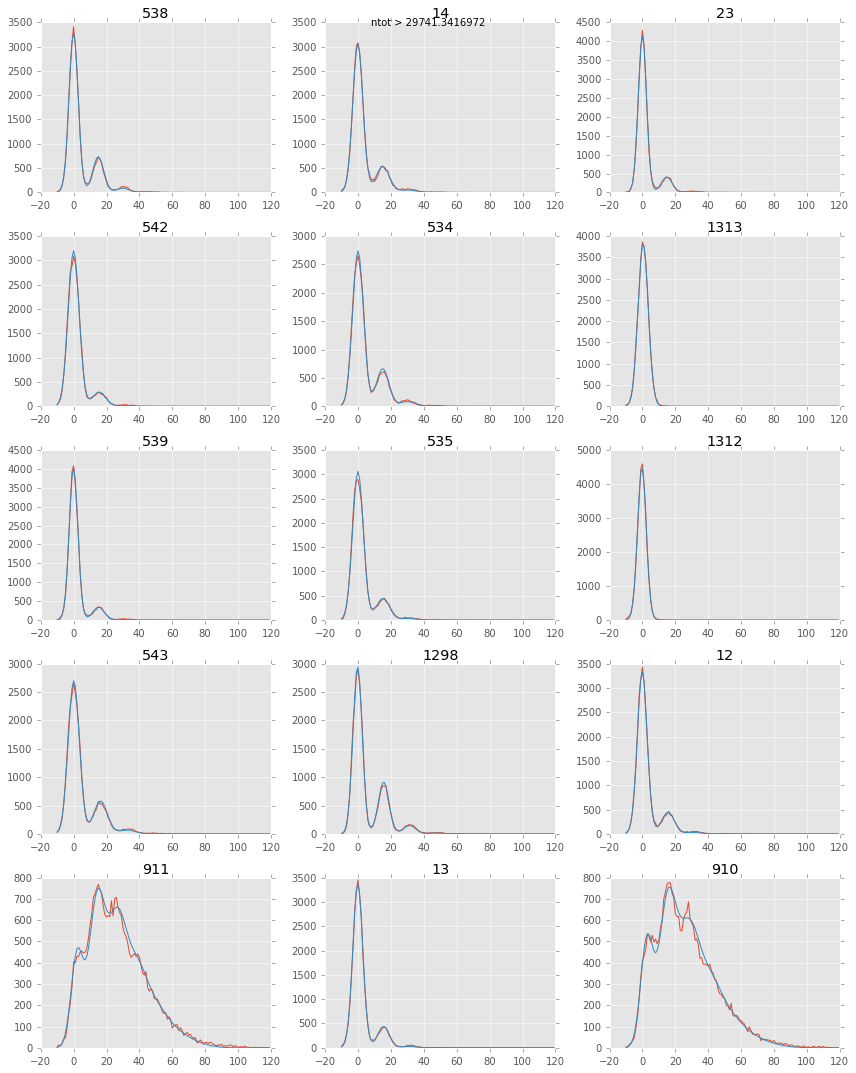

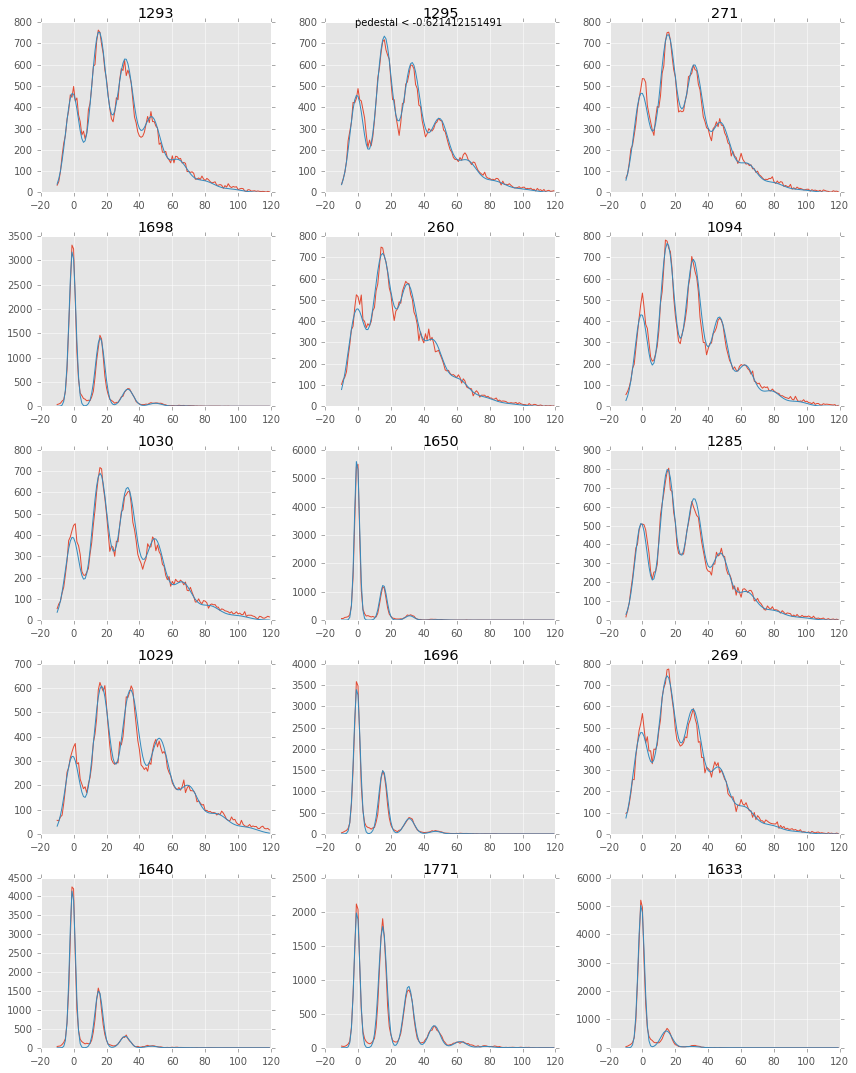

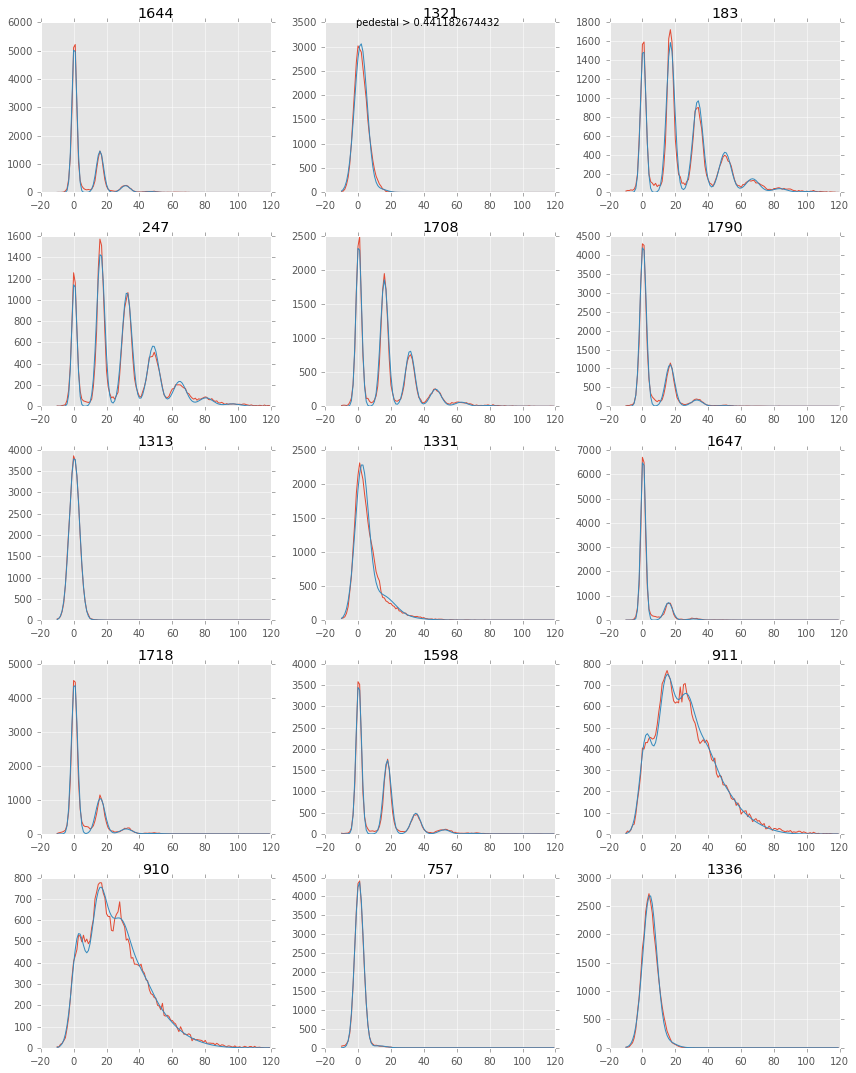

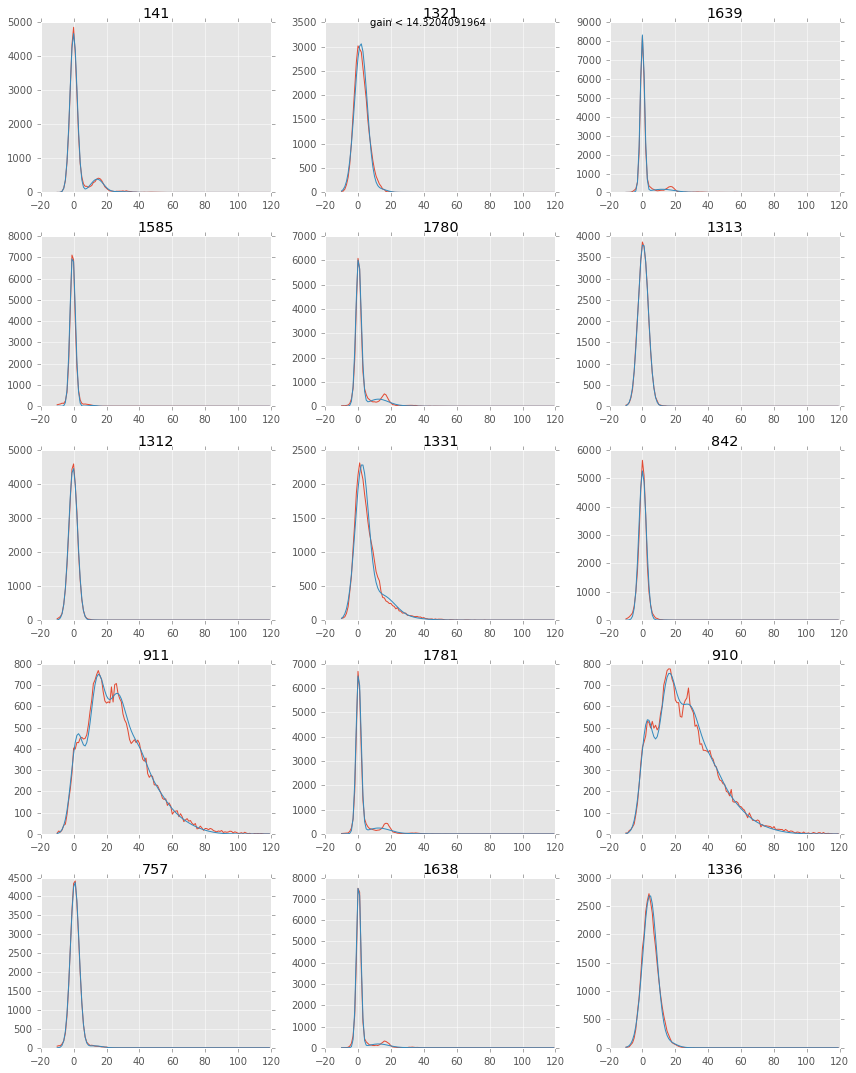

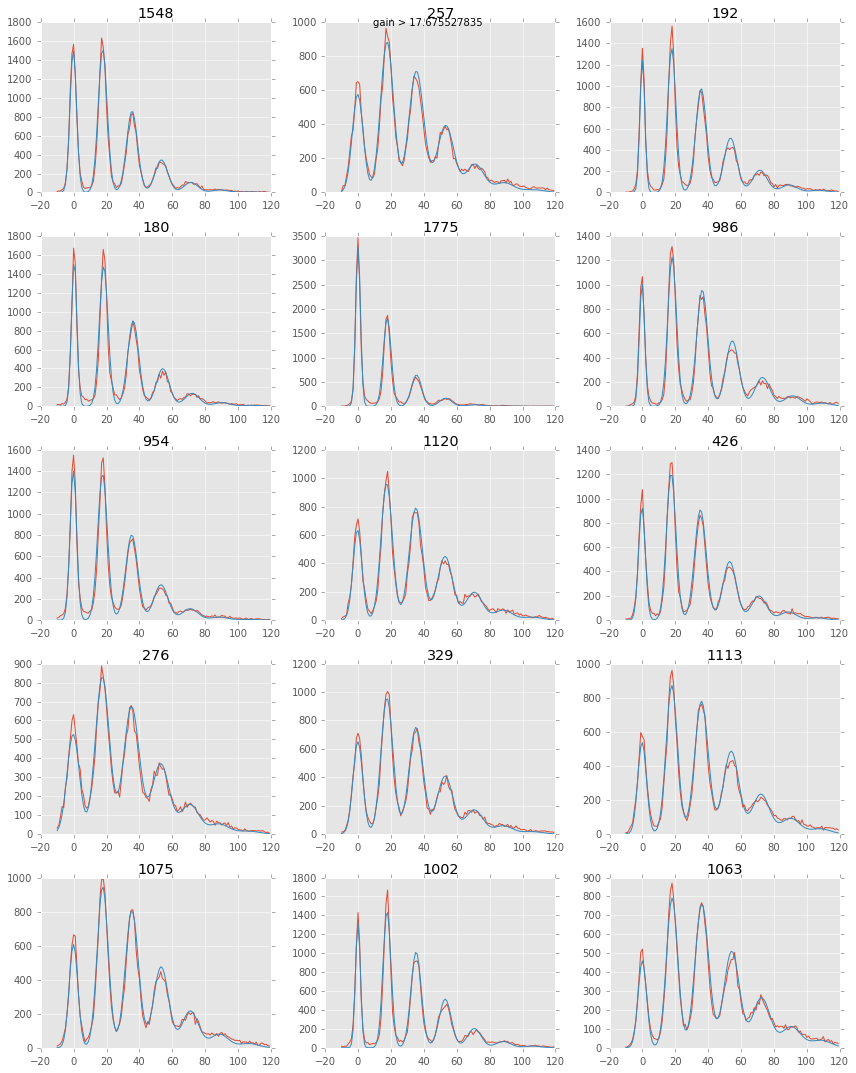

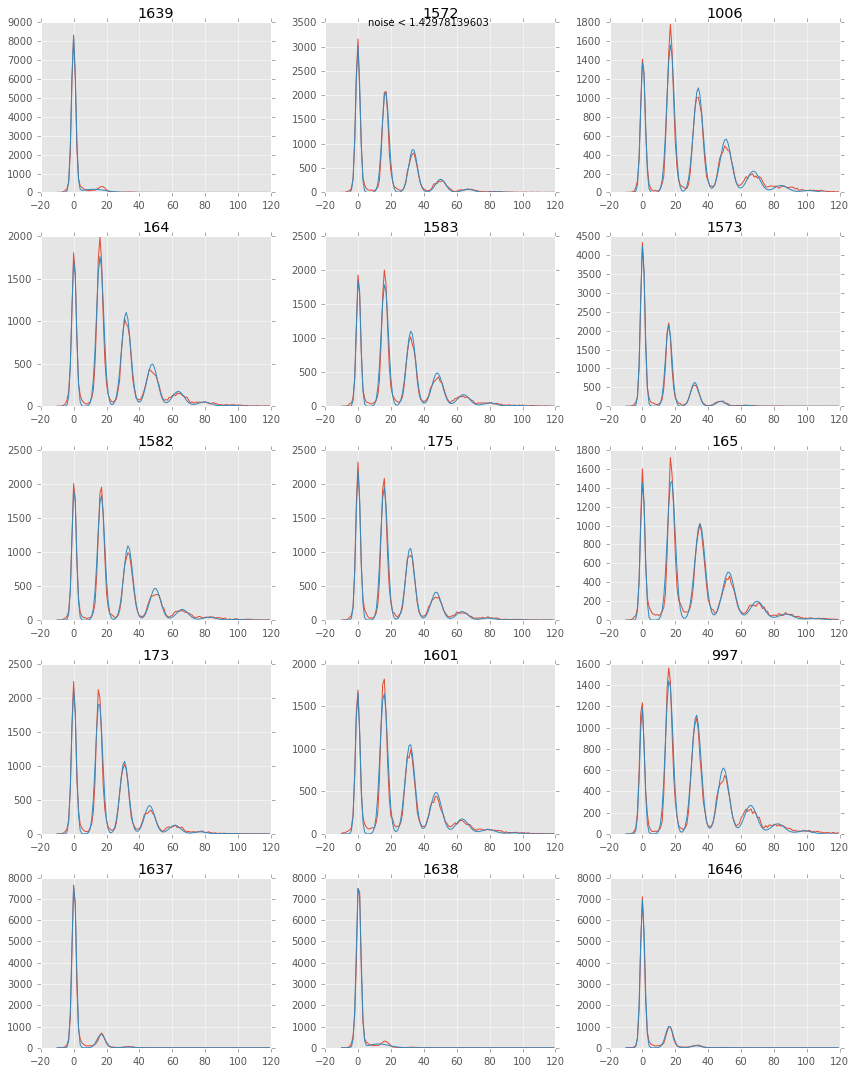

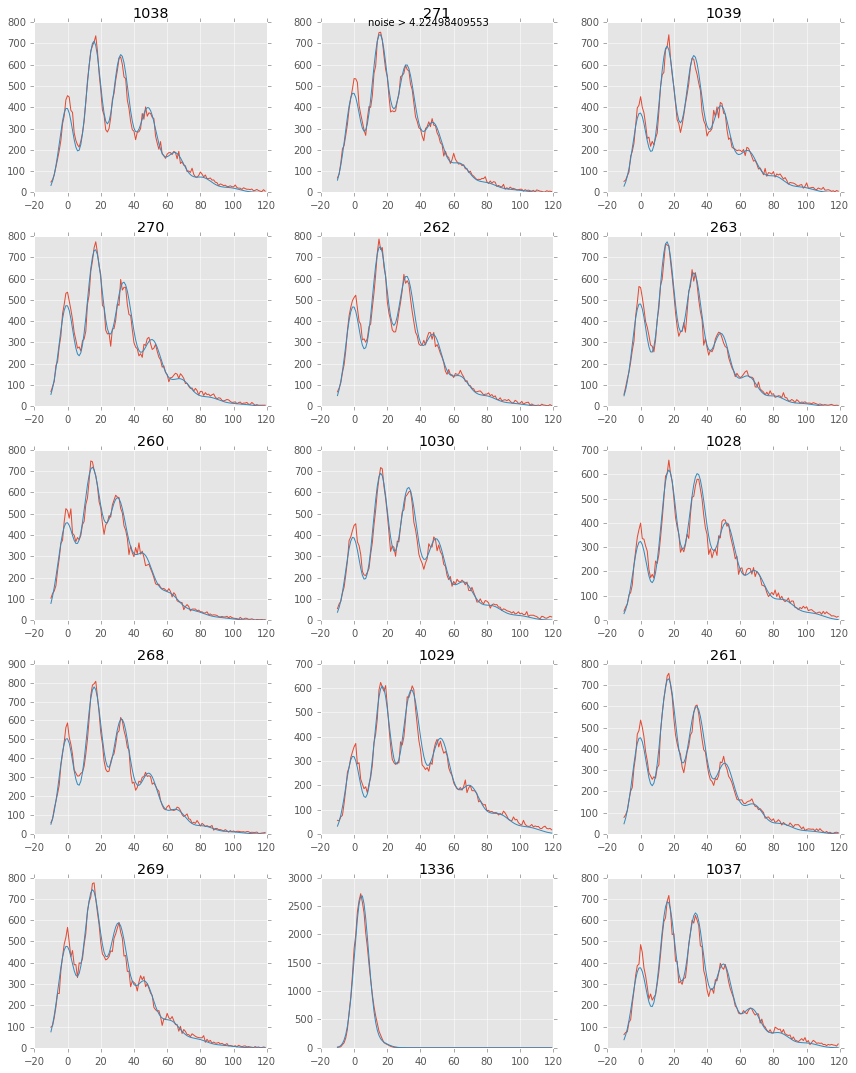

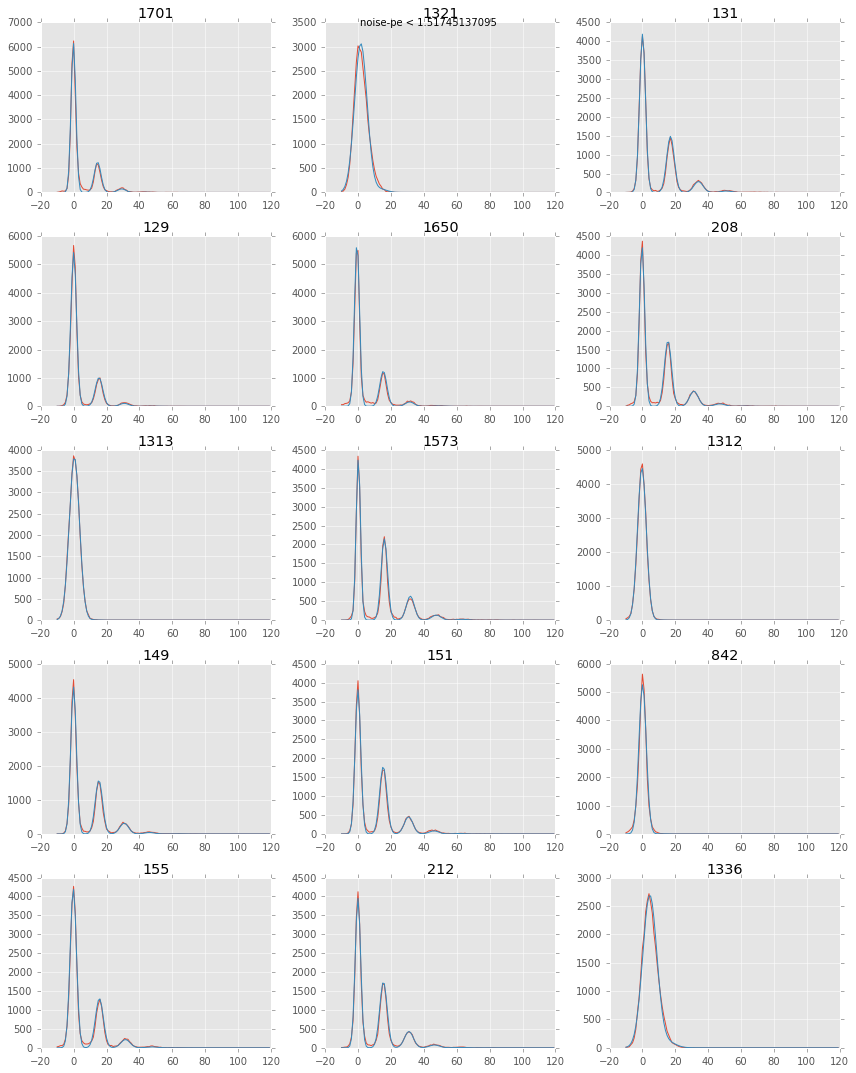

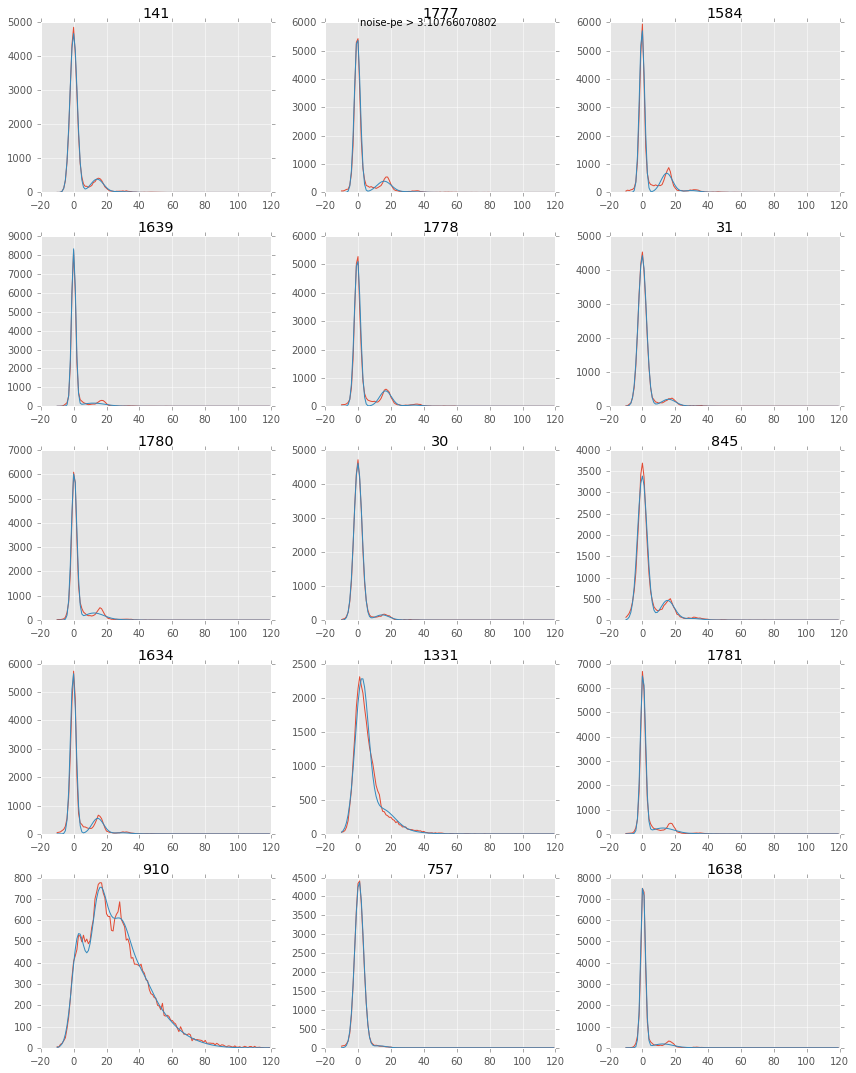

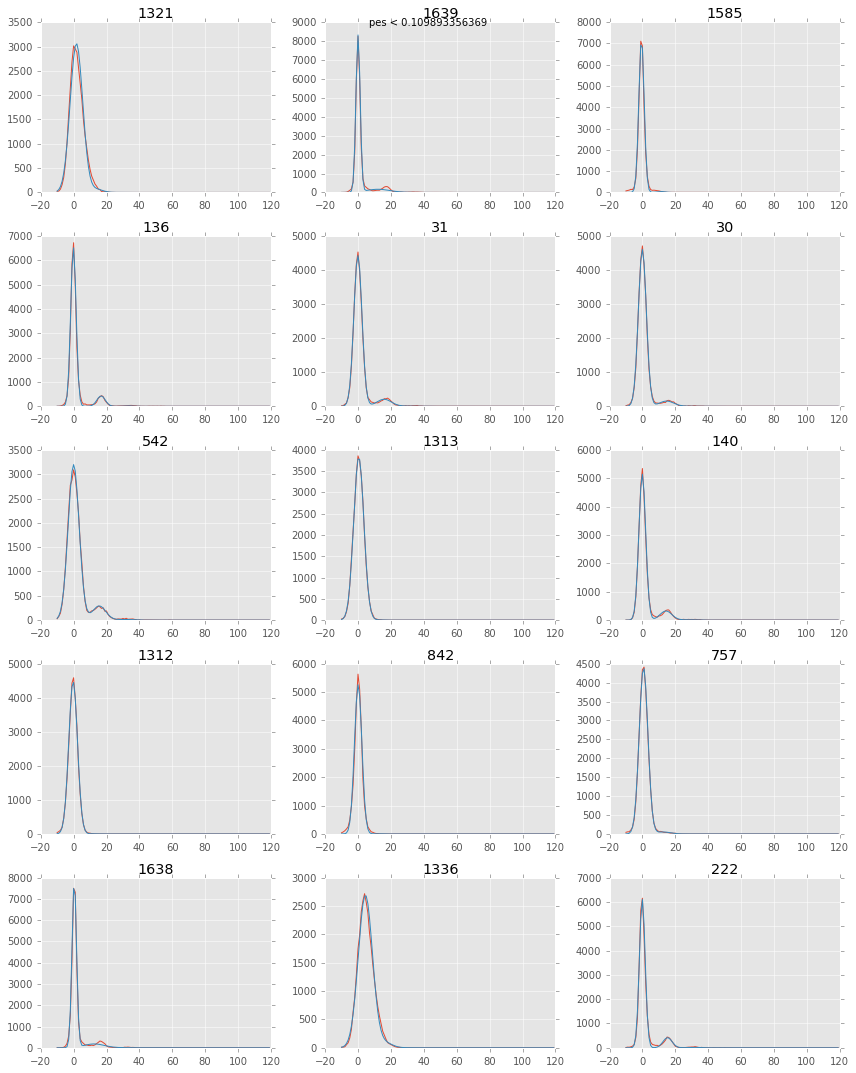

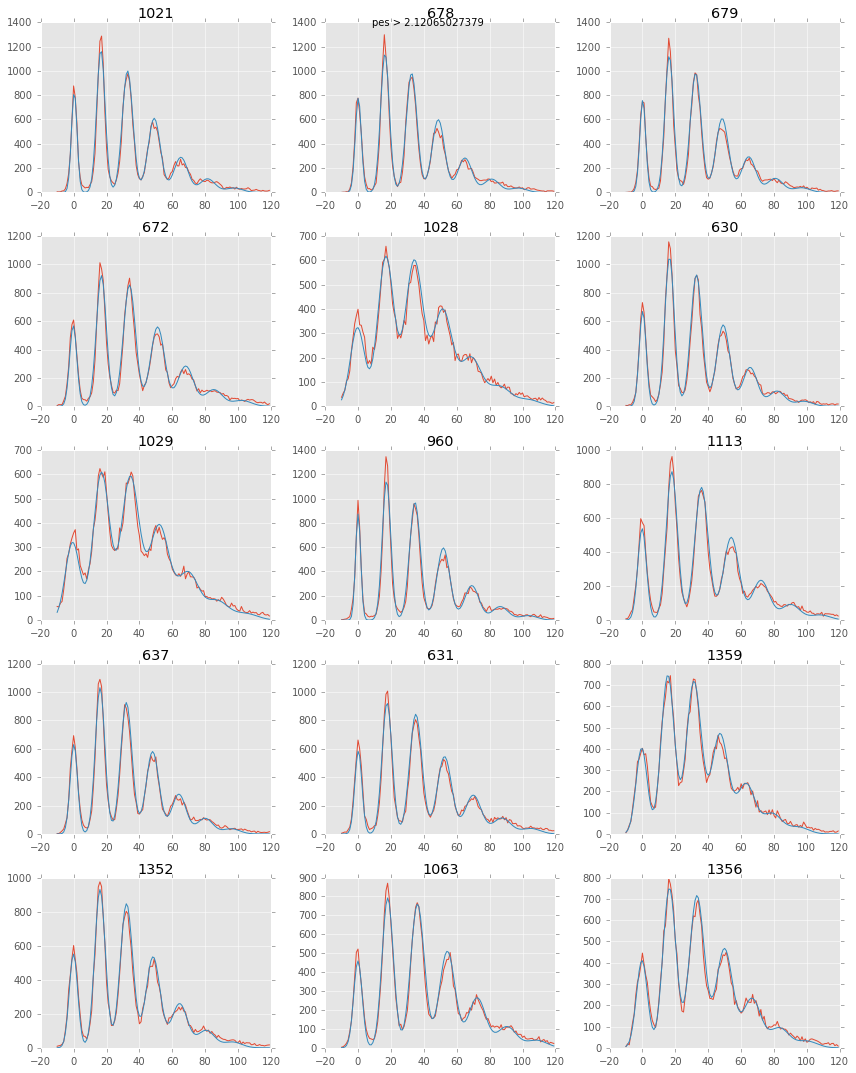

In [52]:
labels=['chi2','ntot','pedestal','gain','noise','noise-pe','pes']
percentile=0.008

pdf = PdfPages(indir+'calf_R'+irun+'_pg_figs_tails.pdf')

for label in labels:
    val0,valf = sc.np_percentile(pan[label],percentile=percentile)
    fpan = pan[pan[label]<=val0]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' < '+str(val0)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
    fpan = pan[pan[label]>=valf]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' > '+str(valf)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
        
pdf.close()
#    fpan
#    raw_input('enter key')

That's all folks!